# Denoising Autoencoder

In [1]:
import numpy as np
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.utils import save_image
from PIL import Image
from birdclassifier import BirdDataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/grads/hassledw/miniconda3/envs/genai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define the Autoencoder Structure

In [2]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, input_channels, hidden_size):
        super(DenoisingAutoEncoder, self).__init__()
        self.latent_dim = hidden_size // 20
        self.mean_layer = nn.Linear(hidden_size // 16, self.latent_dim) # Layer to compute mean of latent distribution
        self.logvariance_layer = nn.Linear(hidden_size // 16, self.latent_dim)  # Layer to compute log variance of latent distribution

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_channels, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size // 2,  hidden_size // 4),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size // 4, hidden_size // 8),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size // 8,  hidden_size // 16)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, hidden_size // 16),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size // 16, hidden_size // 8),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size // 8, hidden_size // 4),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size // 4, hidden_size // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size // 2, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, input_channels),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoder_out = self.encoder(x)

        mean_params = self.mean_layer(encoder_out)
        logvariance_params = self.logvariance_layer(encoder_out)
        latent = self.sample_latent(mean_params, logvariance_params)
        out = self.decoder(latent)
        return out
    
    def sample_latent(self, means, logvariances):
        """
        Use the reparameterization trick to get latents

        Returns:
        - latent_samples: Tensor containing latents (N, latent_dim)
        """
        latent_samples = None

        # Implement the reparameterization trick by:
        # (1) Generating random noise from a standard normal distribution
        noise = torch.randn_like(means)
        # (2) Scaling the noise by the square root of the variance parameters
        std = torch.sqrt(torch.exp(logvariances))
        # (3) Shifting the scaled noise by the mean parameters
        latent_samples = means + (std * noise)

        return latent_samples

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # Load a pre-trained VGG-16 model.
        vgg = models.vgg16(pretrained=True).features
        
        # We'll use these layers' outputs as points for perceptual comparison
        self.layers = [vgg[0],  # Conv1
                       vgg[5],  # Conv2
                       vgg[10], # Conv3
                       vgg[17], # Conv4
                       vgg[24]] # Conv5
        # Freeze parameters. We do not need to train VGG.
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, input_img, target_img):
        loss = 0.0
        x = input_img
        y = target_img
        for layer in self.layers:
            x = layer(x)
            y = layer(y)
            loss += F.mse_loss(x, y)
        return loss


def tensor_to_image(tensor_imgs):
    '''
    A helper function that converts a transformed adversarial tensor 
    into an image that visualizable.

    tensor_imgs: tensors of images
    '''
    images = []
    for tensor in tensor_imgs:
        min_value = 0.0
        max_value = 1.0
        tensor = (tensor - min_value) / (max_value - min_value)
        tensor *= 255.0

        tensor = tensor.to(torch.uint8)
        numpy_image = tensor.cpu().numpy()

        pil_image = Image.fromarray(numpy_image.transpose(1, 2, 0))  # Channels last

        images.append(pil_image)

    return images


def plot_images(reconstructed_images):
    plt.figure(figsize=(15, 5))  # Adjust the (width, height) as needed
    plt.axis('off')
    plt.title("Reconstructed Batch 1", fontsize=18)

    # labels = [test_label, test_label, attack_label, defend_label]
    n_examples = len(reconstructed_images)

    for i, image in enumerate(reconstructed_images):
        plt.subplot(1, n_examples, i + 1)
        plt.axis('off')
        plt.title(f"{i}")
        imgplot = plt.imshow(image)
        # plt.text(0.5, -0.10, f"Label {labels[i]}", ha='center', transform=plt.gca().transAxes)
    plt.show()

## Define the Dataset

In [3]:
test_ds = BirdDataset("./bird-data", "test")
test_dl = DataLoader(test_ds, batch_size = 16, shuffle = False, num_workers = 4)

attack_ds = BirdDataset("./bird-data", "FGSM25-test")
attack_dl = DataLoader(attack_ds, batch_size = 16, shuffle = False, num_workers = 4)

## Run the Autoencoder Network

In [4]:
model = DenoisingAutoEncoder(224*224*3, 1024).to(device)
# Validation using MSE Loss function
loss_function = nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)

### Training Loop

Epoch 0, loss: 229.45614624023438


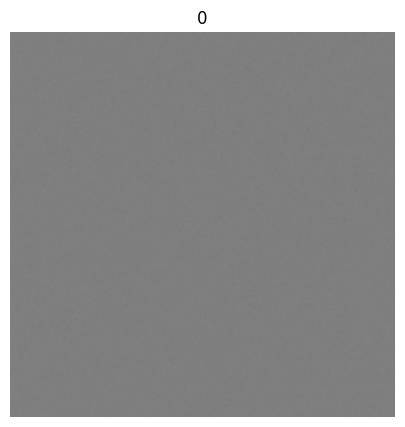

KeyboardInterrupt: 

In [5]:
model.train()
num_epochs = 20
batch_loss = 0
reconsructed_batch = []
for epoch in range(num_epochs):
    # Training
    for batch in zip(test_dl, attack_dl):
        clean_data, attack_data = batch
        X_clean, y_clean = clean_data
        X_attack, y_attack = attack_data

        X_clean = X_clean.reshape(X_clean.shape[0], -1).to(device)
        X_attack = X_attack.reshape(X_attack.shape[0], -1).to(device)

        reconstructed = model(X_attack)

        loss = loss_function(reconstructed, X_clean)
        reconstructed_batch = reconstructed
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss += loss

    print(f"Epoch {epoch}, loss: {batch_loss}")
    reconstructed_images = tensor_to_image(reconstructed_batch[:4].reshape(-1, 3, 224, 224))
    plot_images(reconstructed_images)

    batch_loss = 0

In [ ]:
torch.save(model.state_dict(), "./saved_models/denoising-autoencoder.pth")

### Run Inference

In [ ]:
reconstructed_batch = []
with torch.no_grad():
    for batch in attack_dl:
        X_attack, y_attack = batch
        X_attack = X_attack.reshape(X_attack.shape[0], -1).to(device)
        X_attack.requires_grad_ = True

        reconstructed = model(X_attack)
        reconstructed_batch=reconstructed.reshape(-1, 3, 224, 224)
        break


reconstructed_images = tensor_to_image(reconstructed_batch[:4])
        